# Lab6.3-Topic-modelling

This notebook shows how to build a topic model using Latent Dirichlet Allocation using the Sklearn package.

Credits: This notebook is an adaptation of the work of Shashank Kapadia:

https://github.com/kapadias/mediumposts/blob/master/nlp/published_notebooks/

Here you can download the NIPS Papers dataset in CSV format: https://www.kaggle.com/benhamner/nips-papers


In [1]:
# Importing modules
import pandas as pd

# Read data into papers (make sure that papers.csv is in the same folder as the notebook)
papers = pd.read_csv('papers.csv')

# Print head
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


#### Data Cleaning

Since the goal of this analysis is to perform topic modeling, we will solely focus on the text data from each paper, and drop other metadata columns

In [2]:
# Remove the columns
papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1)

# Print out the first rows of papers
papers.head()

,year,title,abstract,paper_text
0,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


#### Remove punctuation/lower casing

Next, let’s perform a simple preprocessing on the content of paper_text column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text. Note that we care less about the linguistic notion of words and sentences since we treat the text as a basic bag-of-words.

In [3]:
# Load the regular expression library
import re

# Remove punctuation
papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()

0    767\n\nself-organization of associative databa...
1    683\n\na mean field theory of layer iv of visu...
2    394\n\nstoring covariance by the associative\n...
3    bayesian query construction for neural\nnetwor...
4    neural network ensembles cross\nvalidation and...
Name: paper_text_processed, dtype: object

#### Exploratory Analysis

To verify whether the preprocessing happened correctly, we’ll make a word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

You can install WordCloud from the command line following the instructions at:

https://anaconda.org/conda-forge/wordcloud


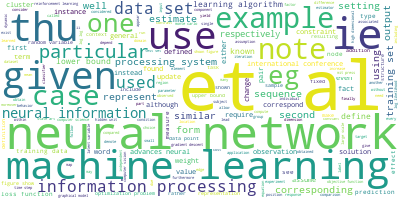

In [4]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

#### Prepare text for LDA analysis

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by converting the documents into a simple vector representation (Bag of Words BOW). Next, we will convert a list of titles into lists of vectors, all with length equal to the vocabulary. For this we use the CountVectorizer package from sklearn and apply the *fit_transform* function to the lists of texts from our pandas frame.

We’ll then plot the ten most frequent words based on the outcome of this operation (the list of document vectors). As a check, these words should also occur in the word cloud. This is done by the Helper function defined below using the matplotlib.

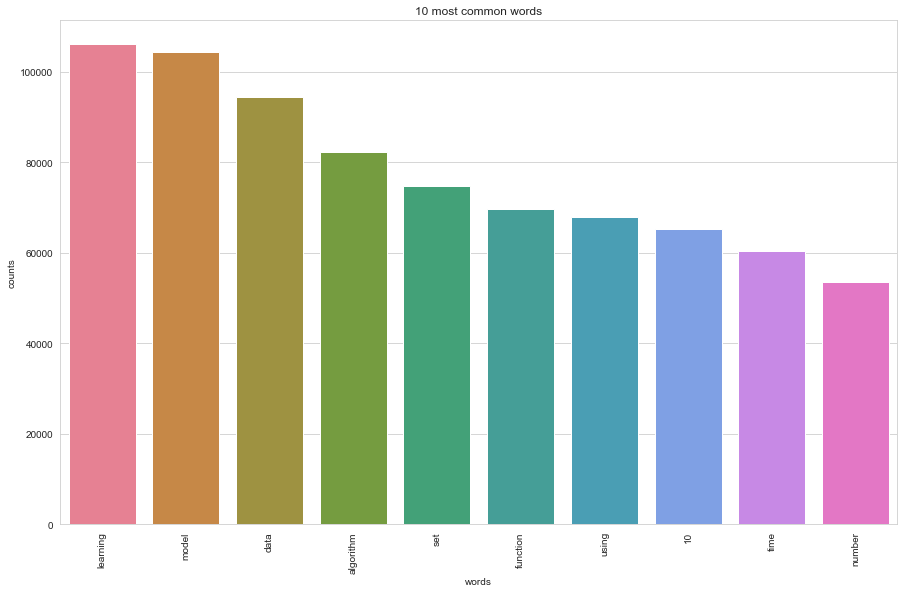

In [5]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(papers['paper_text_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

### LDA model tranining

To keep things simple, we will only tweak the number of topic parameters: number_topics and number_words.

We apply the *fit* function to our count_data.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html


In [6]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
algorithm matrix 10 function data problem log using method methods

Topic #1:
learning model data training using models set image features feature

Topic #2:
algorithm learning set function bound let theorem data problem probability

Topic #3:
model data figure time image using models information 10 neural

Topic #4:
network learning neural input networks time state output function figure


In [7]:
test_data=["my images are difficult to learn", "it takes a lot of time to train a model"]
transformed_test_data= count_vectorizer.transform(test_data)
print(transformed_test_data)

  (0, 120549)	1
  (0, 163063)	1
  (0, 183684)	1
  (1, 189182)	1
  (1, 201629)	1
  (1, 268021)	1
  (1, 272347)	1
  (1, 274903)	1


In [8]:
lda.transform(transformed_test_data)

array([[0.05037571, 0.79754974, 0.05035264, 0.05096347, 0.05075844],
       [0.03416943, 0.8614362 , 0.03417577, 0.03492355, 0.03529504]])

### Analyzing our LDA model

Now that we have a trained model let’s visualize the topics for interpretability. 
To do so, we’ll use a popular visualization package, *pyLDAvis* which is designed to help interactively with:

1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.
For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

You need to install *pyldavis* through the command line, following the instructions:

https://anaconda.org/conda-forge/pyldavis

WARNING: running the next cell takes a long time and you need some memory to run it. However, the result is spectacular.

In [9]:
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis

pyLDAvis.enable_notebook()
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
LDAvis_prepared

/Users/iliamarkov/Documents/work/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.093017  0.016194       1        1  29.543165
1     -0.012471 -0.093036       2        1  21.334036
2     -0.101154  0.048550       3        1  20.720176
3      0.086313 -0.054466       4        1  15.949645
4      0.120329  0.082759       5        1  12.452977, topic_info=       Category           Freq           Term          Total  loglift  logprob
207886  Default   44076.000000        network   44076.000000  30.0000  30.0000
201629  Default  101957.000000          model  101957.000000  29.0000  29.0000
183744  Default  104312.000000       learning  104312.000000  28.0000  28.0000
207921  Default   31821.000000       networks   31821.000000  27.0000  27.0000
208040  Default   44016.000000         neural   44016.000000  26.0000  26.0000
162992  Default   29289.000000          image   29289.000000  25.0000  25.0000
165698  Default   33928.000000          input   33928.000000  24.0000  24.0000
274943  Default   46266.000000       training   46266.000000  23.0000  23.0000
270986  Default   25032.000000        theorem   25032.000000  22.0000  22.0000
163063  Default   18891.000000         images   18891.000000  21.0000  21.0000
80706   Default   81301.000000      algorithm   81301.000000  20.0000  20.0000
261733  Default   34493.000000          state   34493.000000  19.0000  19.0000
96419   Default   25075.000000          bound   25075.000000  18.0000  18.0000
208290  Default   13293.000000        neurons   13293.000000  17.0000  17.0000
218905  Default   22353.000000         output   22353.000000  16.0000  16.0000
272347  Default   59311.000000           time   59311.000000  15.0000  15.0000
280360  Default   12179.000000          units   12179.000000  14.0000  14.0000
183058  Default   16768.000000          layer   16768.000000  13.0000  13.0000
240396  Default    9515.000000         regret    9515.000000  12.0000  12.0000
285582  Default   11642.000000         visual   11642.000000  11.0000  11.0000
117367  Default   10078.000000           deep   10078.000000  10.0000  10.0000
184678  Default   28696.000000            let   28696.000000   9.0000   9.0000
137492  Default   25407.000000       features   25407.000000   8.0000   8.0000
208266  Default    9199.000000         neuron    9199.000000   7.0000   7.0000
138673  Default   52371.000000         figure   52371.000000   6.0000   6.0000
189116  Default   22413.000000           loss   22413.000000   5.0000   5.0000
96481   Default   13358.000000         bounds   13358.000000   4.0000   4.0000
194320  Default   42648.000000         matrix   42648.000000   3.0000   3.0000
213579  Default   13337.000000         object   13337.000000   2.0000   2.0000
154635  Default   14821.000000         hidden   14821.000000   1.0000   1.0000
...         ...            ...            ...            ...      ...      ...
208040   Topic5   17705.300030         neural   44016.669082   1.1725  -4.8347
30683    Topic5    2241.363038           1988    3066.111962   1.7699  -6.9015
280321   Topic5    5218.603567           unit    9496.841353   1.4845  -6.0563
30724    Topic5    2574.306645           1990    3726.362136   1.7134  -6.7630
261733   Topic5   13543.412631          state   34493.382854   1.1483  -5.1027
197050   Topic5    5212.006213         memory    9668.548031   1.4653  -6.0576
289121   Topic5    6517.575430         weight   13277.802203   1.3716  -5.8341
154635   Topic5    7039.373948         hidden   14821.514050   1.3386  -5.7571
289158   Topic5    7475.169306        weights   16511.927868   1.2907  -5.6970
222238   Topic5    4294.284064       patterns    7669.024837   1.5033  -6.2513
110324   Topic5    5729.203430        control   11743.227398   1.3655  -5.9630
125984   Topic5    4536.546117       dynamics    8752.906342   1.4260  -6.1964
240664   Topic5    3440.929271  reinforcement    5815.699373   1.5584  -6.4728
183744   Topic5   21977.

## End of this notebook